In [1]:
import torch
import gensim
from model import lstm_crf
from dataset import Dataset
from underthesea import word_tokenize

# Load pretrained model

In [2]:
w2v_path = 'word2vec_vi_words_300dims/word2vec_vi_words_300dims.txt'
wv_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_path)

In [2]:
level = 'word'
device = 'cuda:0'
corpus = Dataset(train_path=f'./PhoNER_COVID19/data/{level}/train_{level}.conll',
                 val_path=f'./PhoNER_COVID19/data/{level}/dev_{level}.conll',
                 test_path=f'./PhoNER_COVID19/data/{level}/test_{level}.conll',
                 batch_size=32,
                 lower_word = True,
                 wv_model = None,
                 )

In [4]:
path = './pretrained/model.pt'
# path = 'out.pt'
model = lstm_crf(
    word_input_dim=len(corpus.word_field.vocab),
    word_embedding_dim=300,
    char_embedding_dim=50,
    char_input_dim=len(corpus.char_field.vocab),
    char_cnn_filter_num=5,
    char_cnn_kernel_size=3,
    lstm_hidden_dim=200,
    output_dim=len(corpus.tag_field.vocab),
    lstm_layers=2,
    char_emb_dropout=0.5,
    word_emb_dropout=0.5,
    cnn_dropout=0.25,
    lstm_dropout=0.1,
    fc_dropout=0.25,
    word_pad_idx=corpus.word_pad_idx,
    char_pad_idx=corpus.char_pad_idx,
    tag_pad_idx=corpus.tag_pad_idx,
    use_char= True
)

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Predict

In [5]:
def predict(data,model, sentence, device = 'cuda', true_tags=None, segment = True):
    model.to(device)
    model.eval()
    # tokenize sentence
    tokens = sentence
    if segment:
        tokens = word_tokenize(sentence,format="text").split()
    
    
    max_word_len = max([len(token) for token in tokens])

    # # transform to indices based on corpus vocab
    numericalized_tokens = [data.word_field.vocab.stoi[token.lower()] for token in tokens]
    numericalized_chars = []
    char_pad_id = data.char_pad_idx
    for token in tokens:
        numericalized_chars.append(
            [data.char_field.vocab.stoi[char] for char in token]
            + [char_pad_id for _ in range(max_word_len - len(token))]
        )


    # find unknown words
    unk_idx = data.word_field.vocab.stoi[data.word_field.unk_token]
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    # begin prediction
    token_tensor = torch.as_tensor(numericalized_tokens)
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    char_tensor = torch.as_tensor(numericalized_chars)
    char_tensor = char_tensor.unsqueeze(0).to(device)
    predictions, _ = model(token_tensor, char_tensor)
    # convert results to tags
    predicted_tags = [data.tag_field.vocab.itos[t] for t in predictions[0]]
    # print inferred tags
    max_len_token = max([len(token) for token in tokens] + [len('word')])
    max_len_tag = max([len(tag) for tag in predicted_tags] + [len('pred')])
    print(
        f"{'word'.ljust(max_len_token)}\t{'unk'.ljust(max_len_token)}\t{'pred tag'.ljust(max_len_tag)}"
        + ("\ttrue tag" if true_tags else "")
    )
    for i, token in enumerate(tokens):
        is_unk = "✓" if token in unks else ""
        print(
            f"{token.ljust(max_len_token)}\t{is_unk.ljust(max_len_token)}\t{predicted_tags[i].ljust(max_len_tag)}"
            + (f"\t{true_tags[i]}" if true_tags else "")
        )
    return tokens, predicted_tags, unks

In [6]:
sentence = corpus.test_dataset[0].word
tags = corpus.test_dataset[0].tag

words, infer_tags, unknown_tokens = predict(data = corpus,
                                            model = model,
                                            sentence = sentence,
                                            device = 'cuda',
                                            true_tags=tags,
                                            segment = False)
print()

word     	unk      	pred tag  	true tag
Từ       	         	O         	O
00       	         	B-DATE    	B-DATE
-        	         	I-DATE    	I-DATE
0        	         	I-DATE    	I-DATE
đến      	         	O         	O
00       	         	B-DATE    	B-DATE
-        	         	I-DATE    	I-DATE
0        	         	I-DATE    	I-DATE
,        	         	O         	O
bệnh_nhân	         	O         	O
được     	         	O         	O
mẹ       	         	O         	O
là       	         	O         	O
bà       	         	O         	O
H.T.P    	✓        	B-NAME    	B-NAME
(        	         	O         	O
00       	         	B-AGE     	B-AGE
tuổi     	         	O         	O
)        	         	O         	O
đón      	         	O         	O
về       	         	O         	O
nhà      	         	O         	O
ở        	         	O         	O
phường   	         	B-LOCATION	B-LOCATION
Phước_Hoà	✓        	I-LOCATION	I-LOCATION
(        	         	O         	O
bằng     	         	O         	O
xe_máy   	  

C:\Users\Asus\Desktop\SE_project\NER\venv\lib\site-packages\torchcrf\__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ..\aten\src\ATen\native\TensorCompare.cpp:333.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


# History of traning 30 epochs

## Plot F1 score & Percentage of predicted sentences correctly on validation set during training phase

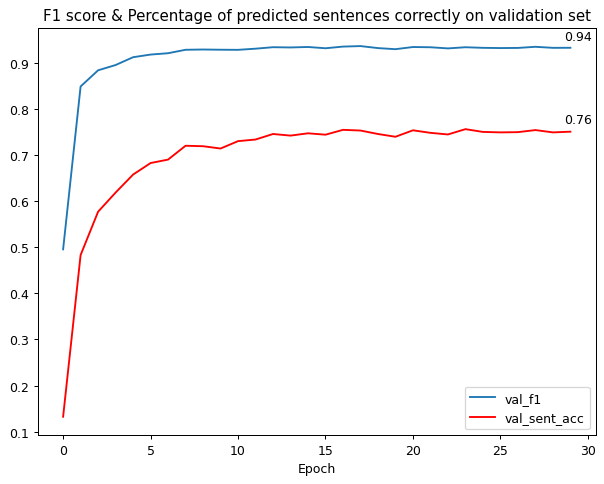

In [101]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 6), dpi=90)
val_f1_his = history['val_f1']
val_sen_acc_his = history['val_sent_acc']
plt.plot(np.arange(30),val_f1_his, label='val_f1')
plt.plot(np.arange(30),val_sen_acc_his,label='val_sent_acc',color = 'red')

for var in (val_f1_his, val_sen_acc_his):
    plt.annotate('%0.2f' % max(var), xy=(1, max(var)), xytext=(-25, 5), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

plt.xlabel('Epoch')
# plt.ylabel('')
plt.title("F1 score & Percentage of predicted sentences correctly on validation set")
plt.legend()
plt.show()

# Evaluate on test set

In [5]:
from sklearn.metrics import f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

def f1_positive(corpus, preds, y, full_report=True):
    index_o = corpus.tag_field.vocab.stoi["O"]
    index_pad = corpus.tag_pad_idx
    # take all labels except padding and "O"
    positive_labels = [i for i in range(len(corpus.tag_field.vocab.itos))
                       if i not in [index_pad, index_o]]

    flatten_pred = [pred for sent_pred in preds for pred in sent_pred]
    flatten_y = [tag for sent_tag in y for tag in sent_tag]

    if full_report:
        # take all names except padding and "O"
        positive_names = [corpus.tag_field.vocab.itos[i] for i in positive_labels]

        print(classification_report(
            y_true=flatten_y,
            y_pred=flatten_pred,
            labels=positive_labels,
            target_names=positive_names
        ))


    return f1_score(
        y_true=flatten_y,
        y_pred=flatten_pred,
        labels=positive_labels,
        average="micro"
    )
    

def sent_accuracy(preds, y):
    assert len(preds) == len(y)
    count = 0
    for i in range(len(preds)):
        if preds[i] == y[i]:
            count += 1

    return count / len(preds)



device = 'cuda'
model.to(device)
model.eval()
with torch.no_grad():
    loss_test = 0
    true_tags_test = []
    pred_tags_test = []
    test_iter = corpus.test_iter
    for batch in test_iter:
        words = batch.word.to(device)
        chars = batch.char.to(device)
        true_tags = batch.tag.to(device)
        
        pred_tags, batch_loss = model(words, chars, true_tags)
        
        pred_tags_test += pred_tags
        true_tags_test += [[tag for tag in sent_tag if tag != corpus.tag_pad_idx]
                            for sent_tag in true_tags.permute(1, 0).tolist()]

print('Percentage of predicted sentences correctly on testing data: ')
print(sent_accuracy(pred_tags_test, true_tags_test))
print('--------------------------------------------------------------')
f1_score = f1_positive(corpus ,pred_tags_test, true_tags_test)

Percentage of predicted sentences correctly on testing data: 
0.7166666666666667
--------------------------------------------------------------
                       precision    recall  f1-score   support

           B-LOCATION       0.94      0.93      0.94      4441
           I-LOCATION       0.95      0.88      0.92      4918
         B-PATIENT_ID       0.98      0.99      0.99      2002
               B-DATE       0.99      0.99      0.99      1657
       I-ORGANIZATION       0.94      0.84      0.89      2014
               I-DATE       0.99      0.99      0.99      1756
I-SYMPTOM_AND_DISEASE       0.93      0.72      0.81      1486
B-SYMPTOM_AND_DISEASE       0.91      0.83      0.87      1136
       B-ORGANIZATION       0.93      0.84      0.88       771
                B-AGE       0.97      0.97      0.97       582
             B-GENDER       0.95      0.94      0.95       462
               B-NAME       0.94      0.89      0.92       318
                I-AGE       0.83    

In [77]:
label = []
for i in range(len(corpus.train_dataset)):
    label.extend(corpus.train_dataset[i].tag)
    
from collections import Counter
Counter(label)

Counter({'O': 104750,
         'B-ORGANIZATION': 1137,
         'I-ORGANIZATION': 2545,
         'B-SYMPTOM_AND_DISEASE': 1439,
         'I-SYMPTOM_AND_DISEASE': 1552,
         'B-LOCATION': 5398,
         'B-DATE': 2549,
         'B-PATIENT_ID': 3240,
         'B-AGE': 682,
         'B-NAME': 349,
         'I-DATE': 2500,
         'B-JOB': 205,
         'I-LOCATION': 5242,
         'B-TRANSPORTATION': 226,
         'B-GENDER': 542,
         'I-TRANSPORTATION': 67,
         'I-JOB': 62,
         'I-NAME': 13,
         'I-AGE': 2,
         'I-PATIENT_ID': 11})

In [99]:
label = []
for i in range(len(corpus.val_dataset)):
    label.extend(corpus.val_dataset[i].tag)
    
from collections import Counter
Counter(label)

Counter({'O': 42166,
         'B-ORGANIZATION': 551,
         'I-ORGANIZATION': 1455,
         'B-DATE': 1103,
         'B-SYMPTOM_AND_DISEASE': 766,
         'I-SYMPTOM_AND_DISEASE': 987,
         'B-PATIENT_ID': 1276,
         'B-GENDER': 277,
         'B-AGE': 361,
         'B-JOB': 132,
         'I-JOB': 49,
         'B-LOCATION': 2737,
         'I-LOCATION': 2993,
         'B-NAME': 188,
         'I-DATE': 1118,
         'B-TRANSPORTATION': 87,
         'I-TRANSPORTATION': 25,
         'I-NAME': 5,
         'I-PATIENT_ID': 7})